<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Bangla_Accent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and importing libraries

In [ ]:
!pip install resampy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import resampy

## Importing metadata to access audio files

In [ ]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/metadata.csv')

In [ ]:
metadata.head()

,file_name,folder_name,accent
0,barishal_audio_01.wav,barishal,barishal
1,barishal_audio_02.wav,barishal,barishal
2,barishal_audio_03.wav,barishal,barishal
3,barishal_audio_04.wav,barishal,barishal
4,barishal_audio_05.wav,barishal,barishal


In [ ]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
523,puran_dhaka_audio_86.wav,puran dhaka,puran dhaka
250,chottgram_audio_50.wav,chottogram,chottogram
428,pabna_audio_03.wav,pabna,pabna
228,chottgram_audio_28.wav,chottogram,chottogram
208,chottgram_audio_09.wav,chottogram,chottogram


In [ ]:
len(metadata)

635

## EDA of random audio file

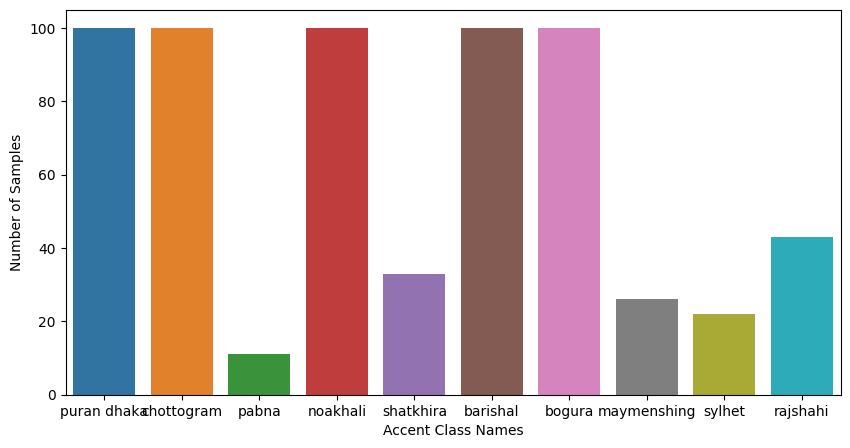

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=metadata['accent'], ax=ax)
plt.xlabel('Accent Class Names')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
import librosa
import librosa.display

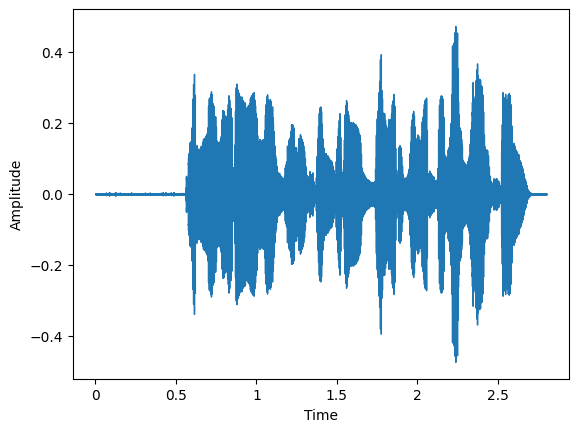

In [ ]:
audio_file = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/barishal/barishal_audio_01.wav'
signal, sr = librosa.load(audio_file, res_type='kaiser_fast')
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

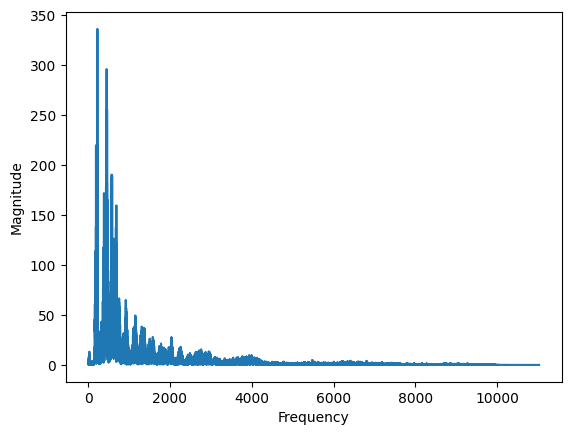

In [ ]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# we have wsed forier transformation to exclude the mirror effect on the data.
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# we can see that most of the energy is concentrated on the lower frequencies and the less energy liaes in the middle range frequency.

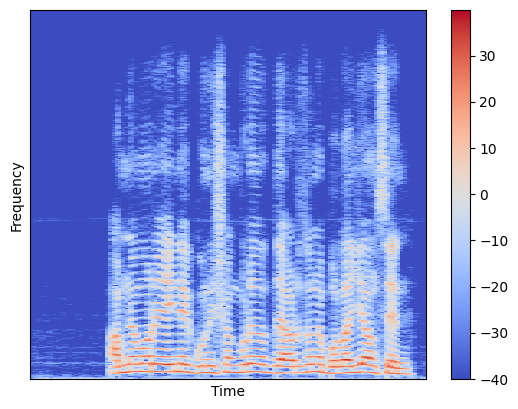

In [ ]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# Through spectrogram analysis we can see that it also states that the most of the energy consists in the lower frequency.
# The spectrogram remains stable through out time.

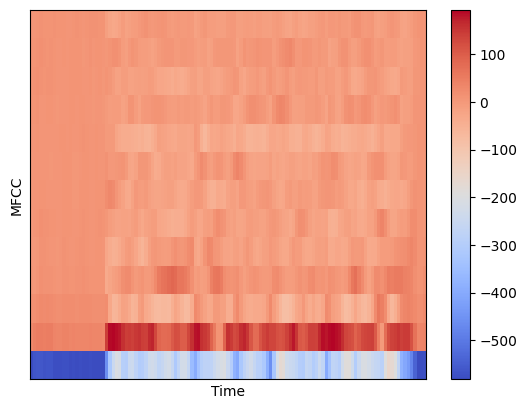

In [ ]:
# finding mfcc

MFCCs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

librosa.display.specshow(MFCCs)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# This is the plot showing the MFCCs over time. There are 13 intervals in this spectrogram. The inteval represents the coffecients.
# We basically seeing here that how different MFCCs evolving over time.

## Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [ ]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [ ]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

635it [01:46,  5.96it/s]


In [ ]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-341.5201, 103.83371, -28.929796, 1.8055182, ...",puran dhaka
1,"[-332.8591, 132.5588, -12.289821, 29.559639, -...",chottogram
2,"[-345.72644, 81.16386, -21.98971, 15.016742, -...",pabna
3,"[-332.63058, 120.516426, -13.524564, 30.3945, ...",chottogram
4,"[-283.31747, 99.24094, -44.311, 16.308073, -18...",chottogram


In [ ]:
extracted_features_df['feature'].tolist()[0]

array([-341.5201    ,  103.83371   ,  -28.929796  ,    1.8055182 ,
        -15.415561  ,   -0.39633518,  -24.232208  ,   -4.778115  ,
        -24.803284  ,   -0.66811335,  -12.885097  ,   -2.542932  ,
          2.7702758 ,  -14.395624  ,  -10.2169075 ,    3.280076  ,
        -16.00841   ,   -2.4530146 ,   -2.4240305 ,  -10.420284  ,
         -5.3383408 ,   -6.8174686 ,   -3.0177965 ,    5.742263  ,
          9.846589  ,   17.015684  ,   14.618568  ,   14.237494  ,
          5.745542  ,    5.593565  ,    5.453853  ,    3.0655103 ,
          6.9274616 ,    1.595932  ,    1.5279926 ,    3.2687325 ,
          2.6262941 ,    2.5802011 ,    1.1355656 ,   -1.654925  ],
      dtype=float32)

## Creating train and test data

In [ ]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(635, 40)

In [ ]:
y.shape

(635,)

### Applying OneHot encoding for the accent classes

In [ ]:
# OneHot Encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = encoder.fit_transform((extracted_features_df['class'].to_numpy()).reshape(-1,1))

In [ ]:
y.shape

(635, 10)

In [ ]:
y = y.toarray()

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### Spliting features into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train

array([[-1.9580597e+02,  1.1105014e+02, -2.5994461e+01, ...,
        -3.2107491e+00,  1.9761004e-01, -1.2425516e+00],
       [-3.6218338e+02,  9.4152748e+01, -4.2699760e+01, ...,
         2.0163352e+00,  2.7184532e+00,  2.1950438e+00],
       [-3.3245471e+02,  1.1661169e+02, -1.3507071e+01, ...,
         8.7147636e+00,  1.3976165e+01,  9.8600750e+00],
       ...,
       [-3.6281360e+02,  1.0318124e+02, -3.1072701e+01, ...,
         2.5868177e+00,  4.5365515e+00,  2.0768409e+00],
       [-3.1822504e+02,  1.4393381e+02, -3.2202961e+01, ...,
        -6.3845568e+00, -3.1093292e+00,  1.4907378e+00],
       [-3.3033615e+02,  1.4143086e+02, -5.9780061e-01, ...,
        -3.8449463e-01,  1.0971119e+00, -9.0789646e-01]], dtype=float32)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train.shape

(508, 40)

In [ ]:
y_train.shape

(508, 10)

## Building ANN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

In [ ]:
y.shape[1]

10

In [ ]:
# No of classes
num_labels=y.shape[1]

In [ ]:
model=Sequential()
# first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# third layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# fourth layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               4100      
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 200)               20200     
                                                                 
 activation_11 (Activation)  (None, 200)               0         
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 200)              

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.optimizers.Adam())

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience = 20,
                                              restore_best_weights = True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 13.2090 - accuracy: 0.1417 - val_loss: 3.2455 - val_accuracy: 0.1260
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 5.7278 - accuracy: 0.1201 - val_loss: 2.1407 - val_accuracy: 0.2283
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 3.8504 - accuracy: 0.1437 - val_loss: 2.0582 - val_accuracy: 0.1732
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 3.0198 - accuracy: 0.1378 - val_loss: 2.0624 - val_accuracy: 0.2598
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 2.7604 - accuracy: 0.1575 - val_loss: 2.0934 - val_accuracy: 0.1811
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 2.5916 - accuracy: 0.1831 - val_loss: 2.0744 - val_accuracy: 0.1575
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 2.4509 - accuracy: 0.1476 - val_loss: 2.0950 - val_accuracy: 0.1339
Epoch

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8031495809555054


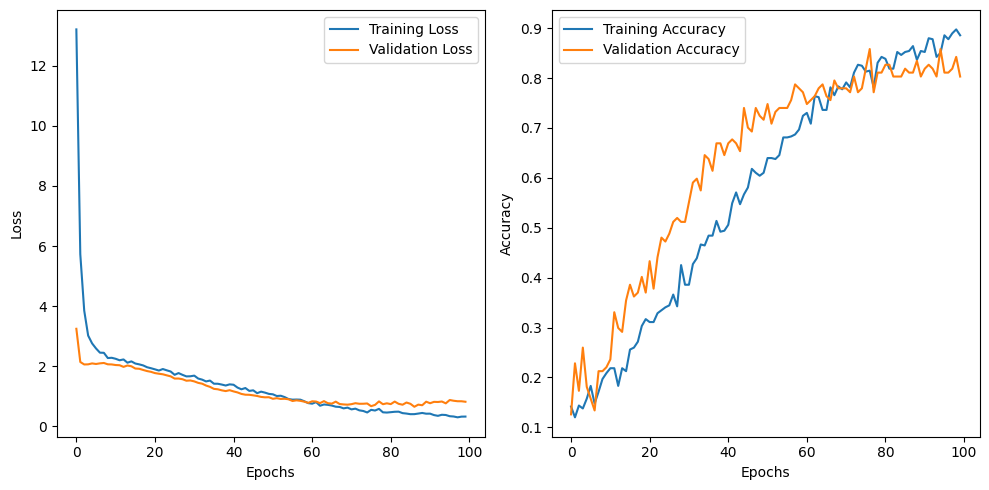

In [ ]:
# Ploting history (also known as a loss curve or a training curve)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Making prediction and converting probability distribution into OneHot encoded vector

In [ ]:
y_pred_ann = model.predict(X_test)

predictions_ann = []

for row in y_pred_ann:
  label = np.zeros(num_labels)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_ann.append(label.tolist())
  label = None

4/4 [==============================] - 0s 6ms/step


In [ ]:
y_test_for_eval = encoder.inverse_transform(y_test)
predictions_ann = encoder.inverse_transform(predictions_ann)

In [ ]:
print(predictions_ann)

[['puran dhaka']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['bogura']
 ['chottogram']
 ['noakhali']
 ['rajshahi']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['puran dhaka']
 ['maymenshing']
 ['bogura']
 ['rajshahi']
 ['bogura']
 ['puran dhaka']
 ['chottogram']
 ['puran dhaka']
 ['chottogram']
 ['noakhali']
 ['barishal']
 ['chottogram']
 ['rajshahi']
 ['chottogram']
 ['noakhali']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['shatkhira']
 ['bogura']
 ['puran dhaka']
 ['chottogram']
 ['maymenshing']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['bogura']
 ['rajshahi']
 ['bogura']
 ['noakhali']
 ['bogura']
 ['maymenshing']
 ['noakhali']
 ['noakhali']
 ['barishal']
 ['puran dhaka']
 ['shatkhira']
 ['maymenshing']
 ['noakhali']
 ['maymenshing']
 ['shatkhira']
 ['puran dhaka']
 ['barishal']
 ['barishal']
 ['chottogram']
 ['shatkhira']
 ['bogura']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['barishal']
 ['maymenshing']
 ['bogura']
 ['ba

### Finding Evaluation parameters

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_ann))
print('Precision score: ', precision_score(y_test_for_eval, predictions_ann, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_ann, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_ann, average='weighted'))

Accuracy score :  0.8031496062992126
Precision score:  0.8136701662292213
Recall score   :  0.8031496062992126
F1 Score       :  0.7988114266058532


In [ ]:
print(classification_report(y_test_for_eval, predictions_ann))

              precision    recall  f1-score   support

    barishal       0.93      0.87      0.90        15
      bogura       0.78      0.88      0.82        24
  chottogram       0.80      0.64      0.71        25
 maymenshing       0.90      1.00      0.95         9
    noakhali       0.88      0.74      0.80        19
       pabna       0.67      1.00      0.80         2
 puran dhaka       0.75      0.94      0.83        16
    rajshahi       0.43      0.50      0.46         6
   shatkhira       0.89      1.00      0.94         8
      sylhet       1.00      0.33      0.50         3

    accuracy                           0.80       127
   macro avg       0.80      0.79      0.77       127
weighted avg       0.81      0.80      0.80       127



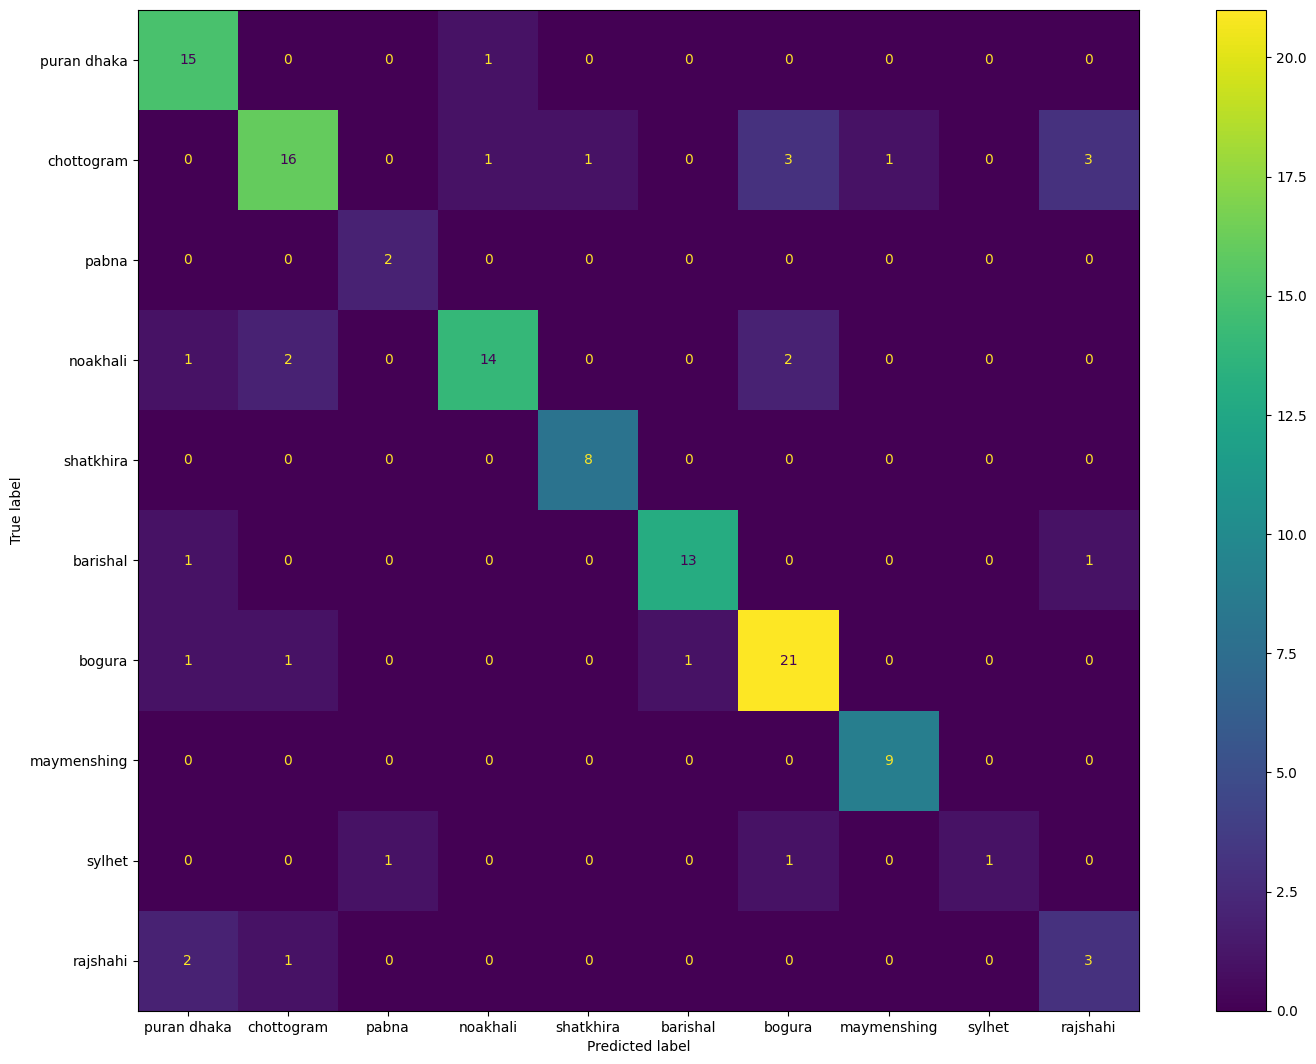

In [ ]:
cm = confusion_matrix(y_test_for_eval, predictions_ann, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(20,13))
disp.plot(ax=ax)
plt.show()

## Building LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
model = tf.keras.Sequential()
# first layer after input layer
model.add(LSTM(100,input_shape=(40,1)))
model.add(Dropout(0.2))
# second layer
model.add(Dense(100, activation='relu'))
# third layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
# forth layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dropout_14 (Dropout)        (None, 100)              

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience = 25,
                                              restore_best_weights = True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 8s 190ms/step - loss: 2.2833 - accuracy: 0.1535 - val_loss: 2.2080 - val_accuracy: 0.2205
Epoch 2/100
16/16 [==============================] - 2s 105ms/step - loss: 2.1459 - accuracy: 0.1693 - val_loss: 2.0736 - val_accuracy: 0.2126
Epoch 3/100
16/16 [==============================] - 1s 78ms/step - loss: 2.0655 - accuracy: 0.2106 - val_loss: 1.9879 - val_accuracy: 0.2835
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 1.9737 - accuracy: 0.2382 - val_loss: 1.8838 - val_accuracy: 0.3071
Epoch 5/100
16/16 [==============================] - 1s 80ms/step - loss: 1.8842 - accuracy: 0.2913 - val_loss: 1.8412 - val_accuracy: 0.3228
Epoch 6/100
16/16 [==============================] - 2s 94ms/step - loss: 1.8414 - accuracy: 0.3012 - val_loss: 1.7722 - val_accuracy: 0.4252
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 1.8107 - accuracy: 0.3484 - val_loss: 1.7462 - val_accuracy: 0.3858
Epo

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6220472455024719


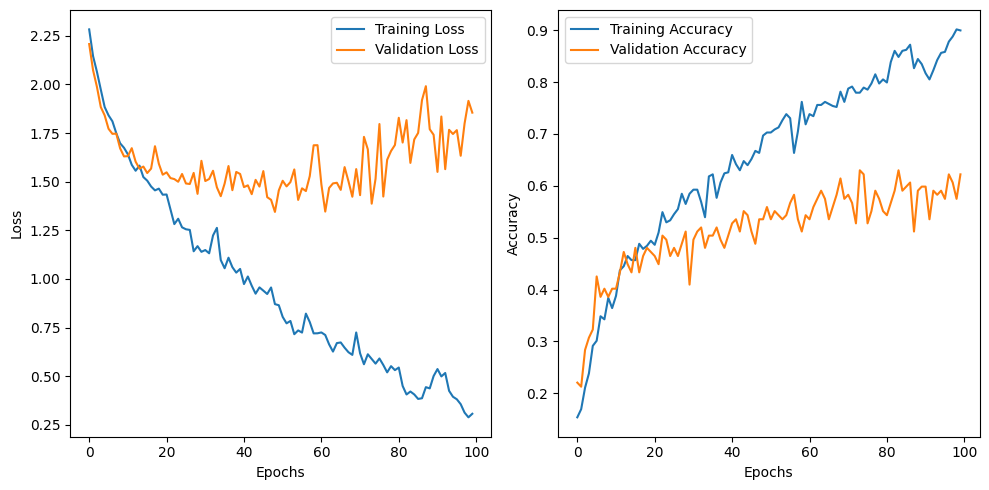

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Making predictions into OneHot encoded format and converting it into real classs names

In [ ]:
y_pred_lstm = model.predict(X_test)

predictions_lstm = []

for row in y_pred_lstm:
  label = np.zeros(num_labels)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_lstm.append(label.tolist())
  label = None

4/4 [==============================] - 1s 13ms/step


In [ ]:
predictions_lstm = encoder.inverse_transform(predictions_lstm)

In [ ]:
print(predictions_lstm)

[['noakhali']
 ['bogura']
 ['noakhali']
 ['puran dhaka']
 ['bogura']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['puran dhaka']
 ['chottogram']
 ['bogura']
 ['noakhali']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['bogura']
 ['rajshahi']
 ['noakhali']
 ['barishal']
 ['rajshahi']
 ['puran dhaka']
 ['rajshahi']
 ['noakhali']
 ['chottogram']
 ['noakhali']
 ['puran dhaka']
 ['shatkhira']
 ['puran dhaka']
 ['puran dhaka']
 ['rajshahi']
 ['maymenshing']
 ['chottogram']
 ['rajshahi']
 ['puran dhaka']
 ['sylhet']
 ['sylhet']
 ['bogura']
 ['bogura']
 ['bogura']
 ['chottogram']
 ['noakhali']
 ['rajshahi']
 ['puran dhaka']
 ['rajshahi']
 ['chottogram']
 ['maymenshing']
 ['noakhali']
 ['maymenshing']
 ['barishal']
 ['puran dhaka']
 ['barishal']
 ['barishal']
 ['chottogram']
 ['puran dhaka']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['puran dhaka']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['barishal']
 ['maymenshing']
 ['bogura']
 ['barishal'

### Finding evaluation parameters

In [ ]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_lstm))
print('Precision score: ', precision_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_lstm, average='weighted'))

Accuracy score :  0.6220472440944882
Precision score:  0.6758932378875981
Recall score   :  0.6220472440944882
F1 Score       :  0.6362324649204713


In [ ]:
print(classification_report(y_test_for_eval, predictions_lstm))

              precision    recall  f1-score   support

    barishal       0.62      0.67      0.65        15
      bogura       0.74      0.71      0.72        24
  chottogram       0.68      0.52      0.59        25
 maymenshing       1.00      0.67      0.80         9
    noakhali       0.70      0.74      0.72        19
       pabna       1.00      1.00      1.00         2
 puran dhaka       0.48      0.62      0.54        16
    rajshahi       0.20      0.33      0.25         6
   shatkhira       1.00      0.50      0.67         8
      sylhet       0.17      0.33      0.22         3

    accuracy                           0.62       127
   macro avg       0.66      0.61      0.62       127
weighted avg       0.68      0.62      0.64       127



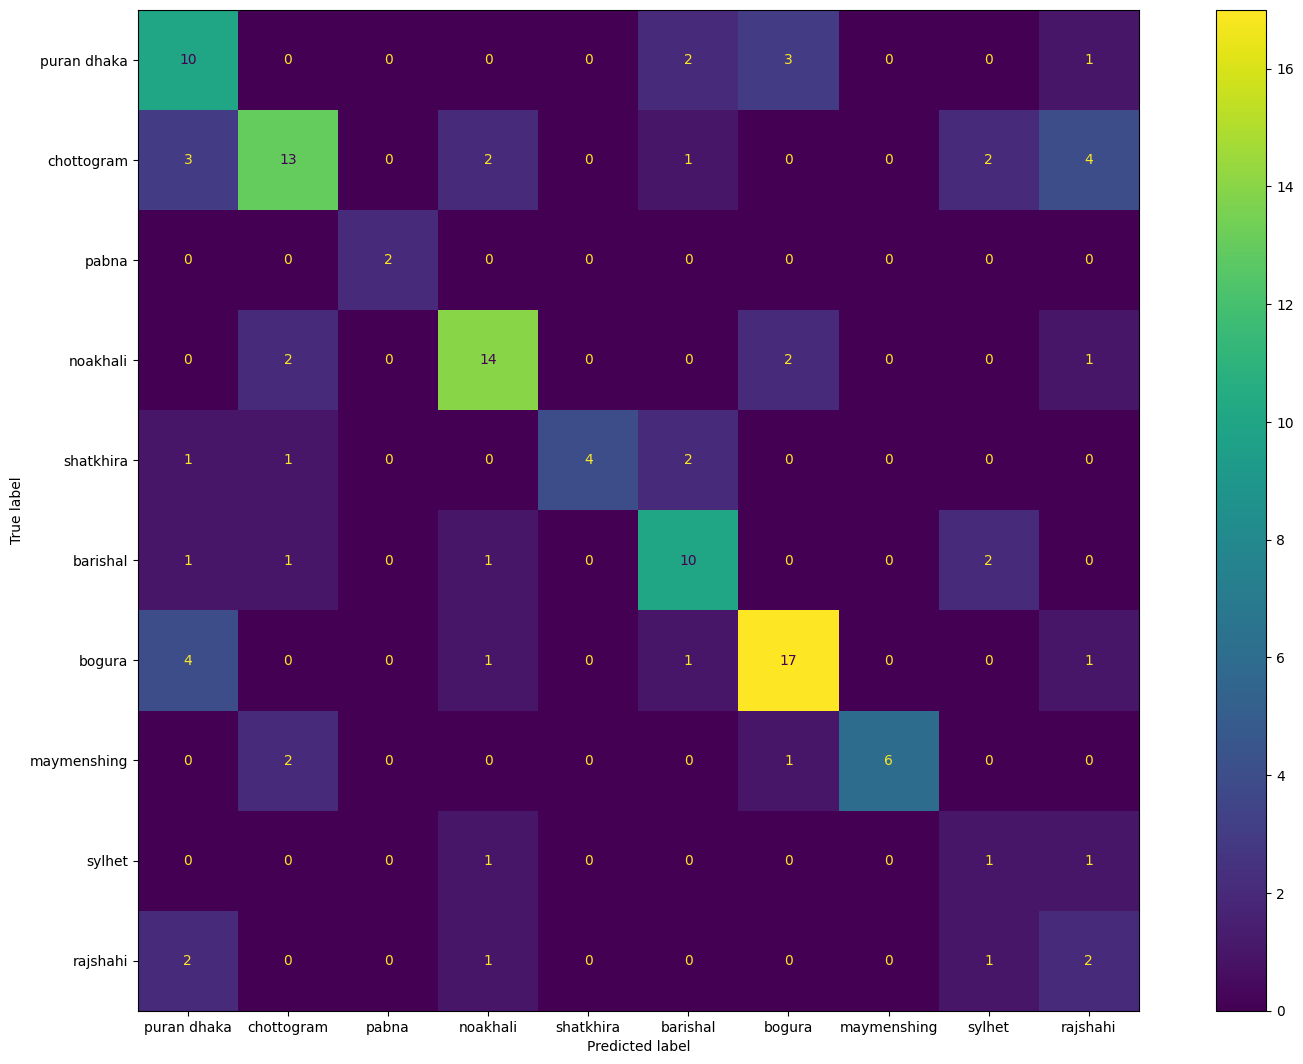

In [ ]:
cm = confusion_matrix(y_test_for_eval, predictions_lstm, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(20,13))
disp.plot(ax=ax)
plt.show()

## Building CNN model

### Applying CNN on neumerical data

In [ ]:
import tensorflow as tf

In [ ]:
shape = X_train.shape

In [ ]:
X_train.shape

(508, 40)

In [ ]:
# Define the CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(10, kernel_size=3, activation='relu', input_shape=(40,1)),
    tf.keras.layers.Conv1D(10, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')  # Replace num_classes with the number of output classes
])

In [ ]:
cnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 38, 10)            40        
                                                                 
 conv1d_17 (Conv1D)          (None, 36, 10)            310       
                                                                 
 flatten_8 (Flatten)         (None, 360)               0         
                                                                 
 dense_27 (Dense)            (None, 10)                3610      
                                                                 
Total params: 3,960
Trainable params: 3,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_model.compile(loss=tf.losses.CategoricalCrossentropy(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
16/16 [==============================] - 1s 19ms/step - loss: 10.5884 - accuracy: 0.0551 - val_loss: 4.0175 - val_accuracy: 0.1260
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 3.8845 - accuracy: 0.1929 - val_loss: 3.0176 - val_accuracy: 0.2126
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 2.8762 - accuracy: 0.2362 - val_loss: 2.3593 - val_accuracy: 0.2835
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 2.2381 - accuracy: 0.3248 - val_loss: 1.9711 - val_accuracy: 0.3858
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 1.9277 - accuracy: 0.4055 - val_loss: 1.8690 - val_accuracy: 0.4016
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 1.6649 - accuracy: 0.4508 - val_loss: 1.6318 - val_accuracy: 0.5197
Epoch 7/50
16/16 [==============================] - 0s 7ms/step - loss: 1.4788 - accuracy: 0.5157 - val_loss: 1.5105 - val_accuracy: 0.5197
Epoch 8/50
16/16 [

In [ ]:
result = cnn_model.evaluate(X_test, y_test)
result

4/4 [==============================] - 0s 5ms/step - loss: 0.7672 - accuracy: 0.8346


[0.7671675682067871, 0.834645688533783]

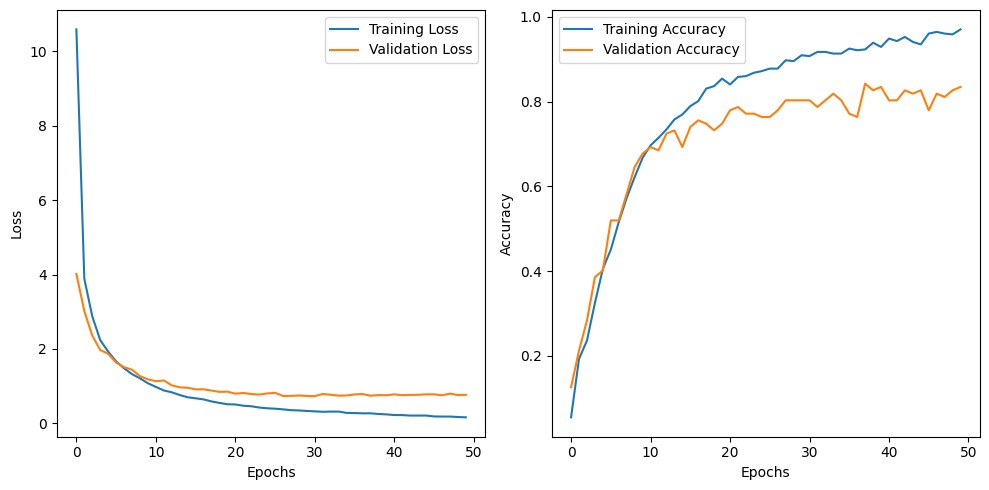

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_cnn = cnn_model.predict(X_test)

predictions_cnn = []

for row in y_pred_cnn:
  label = np.zeros(num_labels)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_cnn.append(label.tolist())
  label = None

predictions_cnn = encoder.inverse_transform(predictions_cnn)

4/4 [==============================] - 0s 4ms/step


In [ ]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_cnn))
print('Precision score: ', precision_score(y_test_for_eval, predictions_cnn, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_cnn, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_cnn, average='weighted'))

Accuracy score :  0.8346456692913385
Precision score:  0.845753655793026
Recall score   :  0.8346456692913385
F1 Score       :  0.8318381252119137


In [ ]:
print(classification_report(y_test_for_eval, predictions_cnn))

              precision    recall  f1-score   support

    barishal       0.88      0.93      0.90        15
      bogura       0.82      0.96      0.88        24
  chottogram       0.83      0.80      0.82        25
 maymenshing       1.00      1.00      1.00         9
    noakhali       0.93      0.68      0.79        19
       pabna       1.00      1.00      1.00         2
 puran dhaka       0.67      0.75      0.71        16
    rajshahi       0.57      0.67      0.62         6
   shatkhira       1.00      1.00      1.00         8
      sylhet       1.00      0.33      0.50         3

    accuracy                           0.83       127
   macro avg       0.87      0.81      0.82       127
weighted avg       0.85      0.83      0.83       127



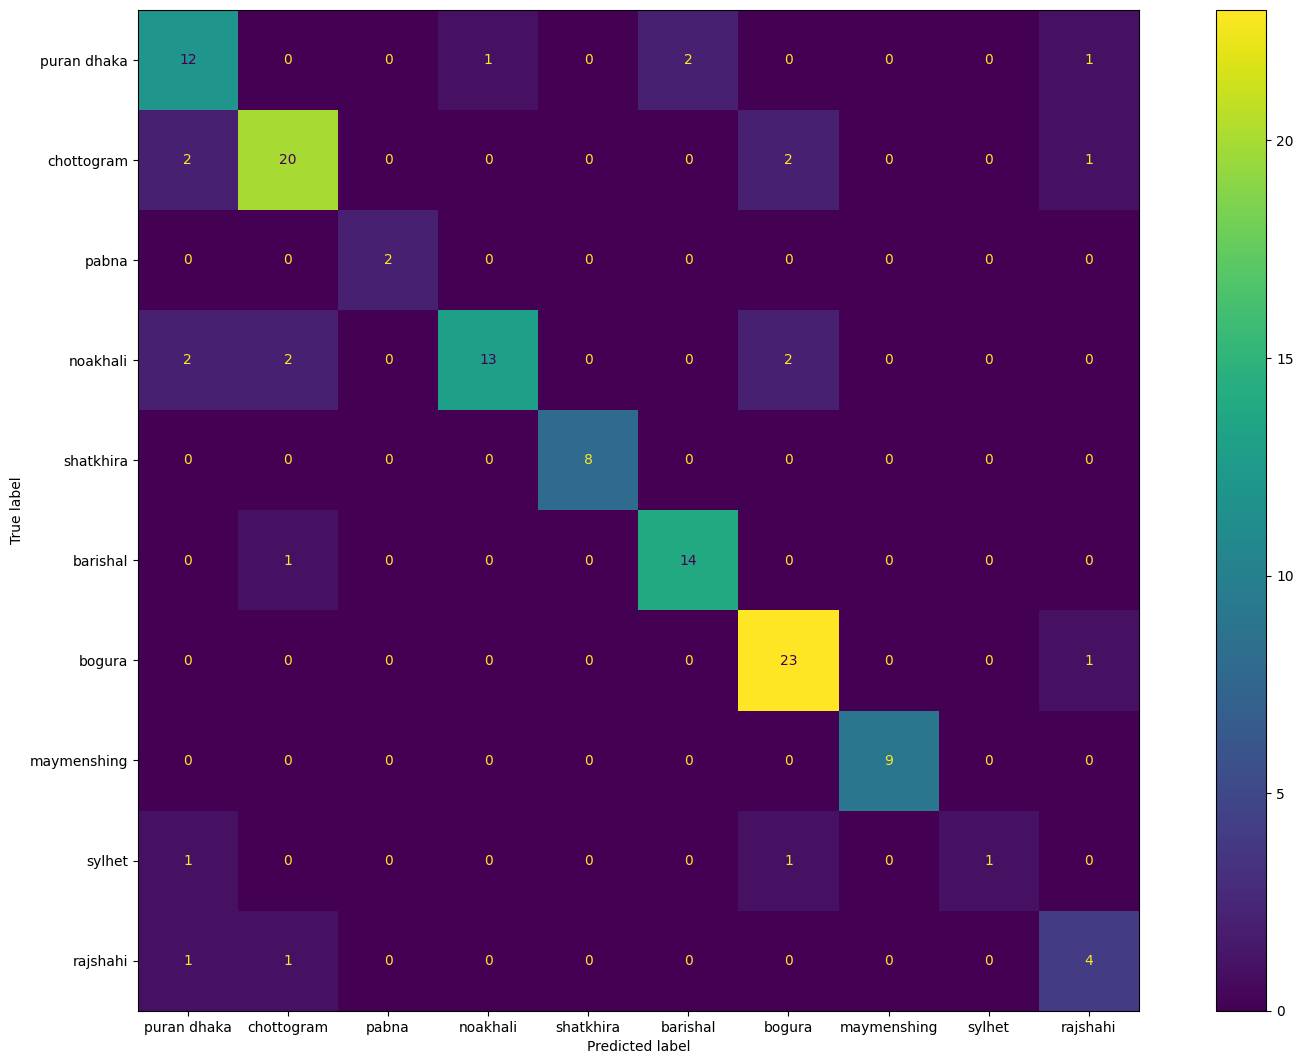

In [ ]:
cm = confusion_matrix(y_test_for_eval, predictions_cnn, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(20,13))
disp.plot(ax=ax)
plt.show()

### Applying CNN (Tiny VGG-16) on spectrogram image

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# preprocess data (get all the pixel values between 0 and 1. also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)

# set up path to our data directories
train_dir = '/content/drive/MyDrive/Datasets/Bangla Accent Spectrogram Dataset'

# import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=6,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=42)

Found 635 images belonging to 10 classes.


In [124]:
tiny_vgg = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3)),
    Activation(activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

tiny_vgg.compile(loss=tf.losses.CategoricalCrossentropy(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=['accuracy'])

In [125]:
tiny_vgg.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 activation_16 (Activation)  (None, 222, 222, 10)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                     

In [126]:
vgg_history = tiny_vgg.fit(train_data, epochs=5)

Epoch 1/5
106/106 [==============================] - 56s 511ms/step - loss: 2.0637 - accuracy: 0.2409
Epoch 2/5
106/106 [==============================] - 59s 553ms/step - loss: 1.5463 - accuracy: 0.4976
Epoch 3/5
106/106 [==============================] - 56s 526ms/step - loss: 0.8702 - accuracy: 0.7339
Epoch 4/5
106/106 [==============================] - 55s 514ms/step - loss: 0.3178 - accuracy: 0.9008
Epoch 5/5
106/106 [==============================] - 56s 530ms/step - loss: 0.1147 - accuracy: 0.9669
